In [2]:
import os
from collections import Counter

# Data processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Image processing
from PIL import Image

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights, vgg19, VGG19_Weights

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing, decomposition, model_selection, pipeline

# Progress bar
from tqdm import tqdm


In [3]:
org_df = pd.read_csv("/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv")
org_df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [4]:
def filter_df_with_existing_images(df, img_dir):
    valid_rows = []

    for idx, row in df.iterrows():
        dia_id = row['Dialogue_ID']
        utt_id = row['Utterance_ID']
        img_name = f"result_dia{dia_id}_utt{utt_id}.png"
        img_path = os.path.join(img_dir, img_name)

        if os.path.exists(img_path):
            valid_rows.append(True)
        else:
            valid_rows.append(False)

    return df[valid_rows].reset_index(drop=True)

In [5]:
df = filter_df_with_existing_images(org_df, '/kaggle/input/meld-output-faces/output_faces')

In [6]:
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9855,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9856,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9857,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9858,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [7]:
# Encode emotion labels to integers (if needed)
label_encoder = LabelEncoder()
df['Emotion'] = label_encoder.fit_transform(df['Emotion'])

In [8]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Emotion'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Emotion'], random_state=42)

# Save the splits
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# EDA

In [9]:
train_df.shape, val_df.shape , test_df.shape

((6902, 11), (1479, 11), (1479, 11))

In [10]:
train_df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
7988,8542,"Okay, yeah, so it's not gonna work.",Phoebe,4,neutral,852,5,1,17,"00:19:34,256","00:19:37,049"
7227,7735,She does want to.,Ross,4,neutral,777,12,6,11,"0:16:06,757","0:16:07,884"
910,967,Yeah???,Monica,4,neutral,96,1,1,17,"00:14:04,635","00:14:05,760"
2508,2691,"Oh wait you two think of me as family?! Oh, I ...",Janice,6,negative,269,1,7,7,"00:12:26,871","00:12:41,259"
7663,8192,No. They said you 'Weren't believable as a hum...,Phoebe,3,positive,822,4,3,4,"00:17:57,701","00:18:05,583"


Emotion
4    3251
3    1200
6     836
0     769
5     474
1     187
2     185
Name: count, dtype: int64


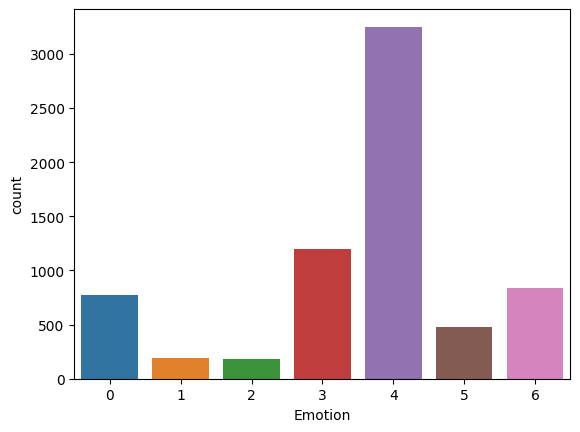

In [11]:
ax = sns.countplot(x=train_df['Emotion'], data=train_df)
print(train_df['Emotion'].value_counts())

Emotion
4    696
3    257
6    179
0    165
5    102
2     40
1     40
Name: count, dtype: int64


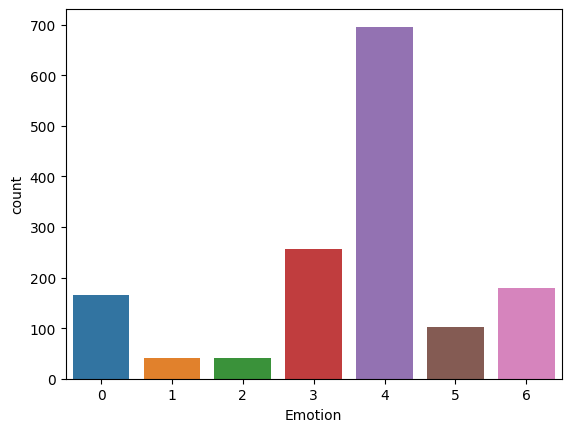

In [12]:
ax = sns.countplot(x=val_df['Emotion'], data=val_df)
print(val_df['Emotion'].value_counts())

Emotion
4    697
3    257
6    179
0    165
5    101
1     40
2     40
Name: count, dtype: int64


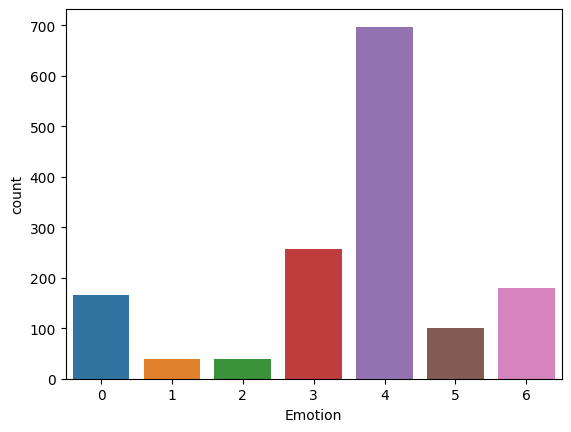

In [13]:
ax = sns.countplot(x=test_df['Emotion'], data=test_df)
print(test_df['Emotion'].value_counts())

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6902 entries, 7988 to 9572
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        6902 non-null   int64 
 1   Utterance     6902 non-null   object
 2   Speaker       6902 non-null   object
 3   Emotion       6902 non-null   int64 
 4   Sentiment     6902 non-null   object
 5   Dialogue_ID   6902 non-null   int64 
 6   Utterance_ID  6902 non-null   int64 
 7   Season        6902 non-null   int64 
 8   Episode       6902 non-null   int64 
 9   StartTime     6902 non-null   object
 10  EndTime       6902 non-null   object
dtypes: int64(6), object(5)
memory usage: 647.1+ KB


In [15]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1479 entries, 598 to 8887
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        1479 non-null   int64 
 1   Utterance     1479 non-null   object
 2   Speaker       1479 non-null   object
 3   Emotion       1479 non-null   int64 
 4   Sentiment     1479 non-null   object
 5   Dialogue_ID   1479 non-null   int64 
 6   Utterance_ID  1479 non-null   int64 
 7   Season        1479 non-null   int64 
 8   Episode       1479 non-null   int64 
 9   StartTime     1479 non-null   object
 10  EndTime       1479 non-null   object
dtypes: int64(6), object(5)
memory usage: 138.7+ KB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1479 entries, 7750 to 5481
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        1479 non-null   int64 
 1   Utterance     1479 non-null   object
 2   Speaker       1479 non-null   object
 3   Emotion       1479 non-null   int64 
 4   Sentiment     1479 non-null   object
 5   Dialogue_ID   1479 non-null   int64 
 6   Utterance_ID  1479 non-null   int64 
 7   Season        1479 non-null   int64 
 8   Episode       1479 non-null   int64 
 9   StartTime     1479 non-null   object
 10  EndTime       1479 non-null   object
dtypes: int64(6), object(5)
memory usage: 138.7+ KB


In [18]:
X_train , y_train = train_df[['Utterance']] , train_df[['Emotion']]
X_cv , y_cv = val_df[['Utterance']] , val_df[['Emotion']]
X_test , y_test = test_df[['Utterance']] , test_df[['Emotion']]

# NLP Module

## Helper Functions

In [29]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [30]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [31]:
lbl_enc = preprocessing.LabelEncoder()
y_train_enc = lbl_enc.fit_transform(y_train.Emotion.values)
y_cv_enc = lbl_enc.transform(y_cv.Emotion.values)
y_test_enc = lbl_enc.transform(y_test.Emotion.values)

## Dataset Preprocessing

In [32]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def preprocess_text(data, text_column='Utterance'):
    """
    Cleans and preprocesses text data using stemming and stopword removal.

    Parameters:
    - data (pd.DataFrame): The dataframe containing the text data.
    - text_column (str): Name of the column containing text to clean.

    Returns:
    - pd.DataFrame: The dataframe with a new column `clean_utterance` and original text column dropped.
    """
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    corpus = []

    for i in range(len(data)):
        review = re.sub('[^a-zA-Z]', ' ', data[text_column].iloc[i])
        review = review.lower().split()
        review = [ps.stem(word) for word in review if word not in stop_words]
        corpus.append(' '.join(review))

    data = data.copy()
    data['clean_utterance'] = corpus
    data.drop(text_column, axis=1, inplace=True)
    return data

In [33]:
X_train = preprocess_text(X_train)
X_cv = preprocess_text(X_cv)
X_test = preprocess_text(X_test)

In [34]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance']))
X_train_tfv =  tfv.transform(X_train['clean_utterance']) 
X_valid_tfv = tfv.transform(X_cv['clean_utterance'])
X_test_tfv = tfv.transform(X_test['clean_utterance'])

In [35]:
X_train_tfv.shape,X_valid_tfv.shape,X_test_tfv.shape

((6902, 2360), (1479, 2360), (1479, 2360))

# Multimodal Architecture

## Defining Custom Dataset

In [49]:
class MultimodalDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_dir, tfidf_matrix, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.tfidf_matrix = tfidf_matrix
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        dia_id = self.df.iloc[idx]['Dialogue_ID']
        utt_id = self.df.iloc[idx]['Utterance_ID']
        img_name = f"result_dia{dia_id}_utt{utt_id}.png"
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        tfidf_vector = torch.tensor(self.tfidf_matrix[idx].toarray(), dtype=torch.float).squeeze()
        label = torch.tensor(self.df.iloc[idx]['Emotion'], dtype=torch.long)

        return tfidf_vector, image, label

In [58]:
# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Instantiate dataset and loader
train_dataset = MultimodalDataset('train.csv', '/kaggle/input/meld-output-faces/output_faces', X_train_tfv, transform=transform)
val_dataset = MultimodalDataset('val.csv', '/kaggle/input/meld-output-faces/output_faces', X_valid_tfv, transform=transform)

In [60]:
# Random sample dataloader to deal with class imbalance
labels = [label for _,_, label in train_dataset]
class_sample_counts = Counter(labels)
weights = [1.0 / class_sample_counts[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

## Defining Model

In [71]:
class MultimodalClassifier(torch.nn.Module):
    def __init__(self, tfidf_dim, num_classes):
        super(MultimodalClassifier, self).__init__()
        #img branch
        self.img_model = models.resnet18(pretrained=False)
        self.img_model.fc = torch.nn.Identity()
        self.img_proj = torch.nn.Linear(512, 512)

        #text branch
        self.tfidf_proj = torch.nn.Linear(tfidf_dim, 512)

        #fusion
        self.dropout = torch.nn.Dropout(0.3)
        self.fusion = torch.nn.Linear(1024, 512)
        self.classifier = torch.nn.Linear(512, num_classes)

    def forward(self, tfidf_input, image_input):
        img_feat = self.img_model(image_input)
        img_feat = self.img_proj(img_feat)
        tfidf_feat = self.tfidf_proj(tfidf_input)

        # Normalize
        img_feat = F.normalize(img_feat, p=2, dim=1)
        tfidf_feat = F.normalize(tfidf_feat, p=2, dim=1)

        combined = torch.cat((img_feat, tfidf_feat), dim=1)
        combined = self.dropout(combined)
        fused = F.relu(self.fusion(combined))
        output = self.classifier(fused)
        return output

## Training and evaluation loop

In [61]:
def train(model, train_loader, val_loader, num_epochs, device, lr=1e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for tfidf_vector, images, labels in loop:
            tfidf_vector, images, labels = tfidf_vector.to(device), images.to(device), labels.to(device)

            outputs = model(tfidf_vector, images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

            loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

        val_acc, val_loss = evaluate(model, val_loader, criterion, device)
        print(f"\nEpoch {epoch+1} Summary: Val Acc = {val_acc:.2f}%, Val Loss = {val_loss:.4f}")
        print("Sample predictions:", preds[:20].cpu().numpy())
        print("Unique preds:", torch.unique(preds).cpu().numpy())

In [68]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    best_val_acc = 0

    with torch.no_grad():
        for tfidf_vector, images, labels in val_loader:
            tfidf_vector, images, labels = tfidf_vector.to(device), images.to(device), labels.to(device)

            outputs = model(tfidf_vector, images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

    val_acc = 100.0 * correct / total
    val_loss = running_loss / len(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'fusion_emotion_best.pth')
        print("Saved model weights")
        
    return val_acc, val_loss


In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalClassifier(tfidf_dim=X_train_tfv.shape[1], num_classes=7).to(device)

train(model, train_loader, val_loader, 20, device, lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/20 [Train]: 100%|██████████| 216/216 [00:17<00:00, 12.28it/s, acc=46.7, loss=1.6] 


Saved model weights

Epoch 1 Summary: Val Acc = 47.06%, Val Loss = 1.5970
Sample predictions: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Unique preds: [4]


Epoch 2/20 [Train]: 100%|██████████| 216/216 [00:16<00:00, 13.41it/s, acc=49, loss=1.28]  


Saved model weights

Epoch 2 Summary: Val Acc = 50.78%, Val Loss = 1.5474
Sample predictions: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4]
Unique preds: [3 4]


Epoch 3/20 [Train]: 100%|██████████| 216/216 [00:16<00:00, 12.87it/s, acc=54.8, loss=1.39]


Saved model weights

Epoch 3 Summary: Val Acc = 52.47%, Val Loss = 1.5268
Sample predictions: [3 4 6 4 4 4 4 4 4 3 4 3 3 4 3 4 4 0 4 3]
Unique preds: [0 3 4 6]


Epoch 4/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.71it/s, acc=60.1, loss=1.2] 


Saved model weights

Epoch 4 Summary: Val Acc = 50.85%, Val Loss = 1.5364
Sample predictions: [4 4 0 6 4 4 4 4 4 4 3 4 4 3 4 3 4 6 4 4]
Unique preds: [0 3 4 6]


Epoch 5/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.89it/s, acc=62.4, loss=1.14] 


Saved model weights

Epoch 5 Summary: Val Acc = 49.83%, Val Loss = 1.5566
Sample predictions: [4 4 0 4 4 6 5 4 4 4 4 0 0 4 3 4 5 4 4 4]
Unique preds: [0 3 4 5 6]


Epoch 6/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.94it/s, acc=64.4, loss=1.22] 


Saved model weights

Epoch 6 Summary: Val Acc = 49.97%, Val Loss = 1.5851
Sample predictions: [0 6 4 4 4 6 4 6 3 4 6 4 4 3 4 4 4 4 0 5]
Unique preds: [0 3 4 5 6]


Epoch 7/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 14.01it/s, acc=65.7, loss=1.34] 


Saved model weights

Epoch 7 Summary: Val Acc = 49.43%, Val Loss = 1.6153
Sample predictions: [4 6 5 4 4 3 4 4 4 6 6 4 4 4 4 4 3 4 4 3]
Unique preds: [3 4 5 6]


Epoch 8/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.90it/s, acc=68.2, loss=0.939]


Saved model weights

Epoch 8 Summary: Val Acc = 47.26%, Val Loss = 1.6438
Sample predictions: [5 4 6 4 0 3 4 3 4 4 4 5 4 6 4 4 4 3 0 6]
Unique preds: [0 3 4 5 6]


Epoch 9/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.92it/s, acc=68.8, loss=0.969]


Saved model weights

Epoch 9 Summary: Val Acc = 47.67%, Val Loss = 1.6812
Sample predictions: [4 6 5 3 6 3 4 4 0 5 0 4 3 3 4 4 4 4 4 1]
Unique preds: [0 1 3 4 5 6]


Epoch 10/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.87it/s, acc=70.1, loss=1.17] 


Saved model weights

Epoch 10 Summary: Val Acc = 47.53%, Val Loss = 1.7098
Sample predictions: [4 4 4 4 3 0 4 4 5 4 0 3 5 4 5 4 5 3 6 4]
Unique preds: [0 3 4 5 6]


Epoch 11/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 14.00it/s, acc=71.7, loss=1.09] 


Saved model weights

Epoch 11 Summary: Val Acc = 46.38%, Val Loss = 1.7507
Sample predictions: [0 4 2 4 4 6 4 4 4 4 4 4 4 4 0 4 3 4 3 0]
Unique preds: [0 2 3 4 6]


Epoch 12/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.97it/s, acc=72.4, loss=0.911]


Saved model weights

Epoch 12 Summary: Val Acc = 46.18%, Val Loss = 1.7680
Sample predictions: [3 4 4 4 4 4 6 4 3 4 4 4 6 3 5 4 1 3 6 4]
Unique preds: [1 3 4 5 6]


Epoch 13/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.77it/s, acc=72.1, loss=1.11] 


Saved model weights

Epoch 13 Summary: Val Acc = 46.59%, Val Loss = 1.7979
Sample predictions: [4 5 4 4 3 3 4 4 0 3 3 4 4 0 4 0 4 6 6 0]
Unique preds: [0 3 4 5 6]


Epoch 14/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 14.01it/s, acc=72.8, loss=0.957]


Saved model weights

Epoch 14 Summary: Val Acc = 46.25%, Val Loss = 1.8198
Sample predictions: [4 4 4 0 4 0 3 6 6 4 4 4 4 4 4 4 4 3 4 6]
Unique preds: [0 3 4 6]


Epoch 15/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.88it/s, acc=73.3, loss=0.958]


Saved model weights

Epoch 15 Summary: Val Acc = 45.50%, Val Loss = 1.8426
Sample predictions: [4 4 4 6 6 6 4 3 4 4 4 4 4 3 5 4 5 4 4 6]
Unique preds: [3 4 5 6]


Epoch 16/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.92it/s, acc=72.8, loss=0.936]


Saved model weights

Epoch 16 Summary: Val Acc = 46.11%, Val Loss = 1.8488
Sample predictions: [4 4 3 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 3 4]
Unique preds: [0 3 4 6]


Epoch 17/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.84it/s, acc=73.7, loss=0.907]


Saved model weights

Epoch 17 Summary: Val Acc = 45.91%, Val Loss = 1.8773
Sample predictions: [4 3 6 6 4 4 4 4 5 6 4 4 0 3 5 3 4 4 4 4]
Unique preds: [0 3 4 5 6]


Epoch 18/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.97it/s, acc=74.8, loss=1.01] 


Saved model weights

Epoch 18 Summary: Val Acc = 45.30%, Val Loss = 1.8870
Sample predictions: [6 4 4 0 6 4 5 3 4 4 6 3 4 4 4 4 4 3 3 4]
Unique preds: [0 3 4 5 6]


Epoch 19/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 14.05it/s, acc=73.8, loss=0.795]


Saved model weights

Epoch 19 Summary: Val Acc = 45.37%, Val Loss = 1.8826
Sample predictions: [0 6 4 4 4 5 1 4 4 4 3 0 3 3 0 4 4 4 1 4]
Unique preds: [0 1 3 4 5 6]


Epoch 20/20 [Train]: 100%|██████████| 216/216 [00:15<00:00, 13.82it/s, acc=75.1, loss=0.905]


Saved model weights

Epoch 20 Summary: Val Acc = 44.42%, Val Loss = 1.9083
Sample predictions: [1 0 3 6 4 5 4 3 0 3 0 4 5 0 3 4 4 1 3 4]
Unique preds: [0 1 3 4 5 6]
